# Simple iteration for systems of linear equations

First, generate a random diagonally dominant matrix, for testing.

In [22]:
import numpy as np
rndm = np.random.RandomState(1234)

n = 10
A = rndm.uniform(size=(n, n)) + np.diagflat([15]*n)
b = rndm.uniform(size=n)

# I.  Jacobi iteration

Given

$$
A x = b
$$

separate the diagonal part $D$,

$$ A = D + (A - D) $$

and write

$$
x = D^{-1} (D - A) x + D^{-1} b\;.
$$

Then iterate

$$
x_{n + 1} = B x_{n} + c\;,
$$

where 

$$
B = D^{-1} (A - D) \qquad \text{and} \qquad c = D^{-1} b
$$


Let's construct the matrix and the r.h.s. for the Jacobi iteration

In [23]:
diag_1d = np.diag(A)

B = -A.copy()
np.fill_diagonal(B, 0)

D = np.diag(diag_1d)
invD = np.diag(1./diag_1d)
BB = invD @ B 
c = invD @ b


In [24]:
# sanity checks
from numpy.testing import assert_allclose

assert_allclose(-B + D, A)


# xx is a "ground truth" solution, compute it using a direct method
xx = np.linalg.solve(A, b)

np.testing.assert_allclose(A@xx, b)
np.testing.assert_allclose(D@xx, B@xx + b)
np.testing.assert_allclose(xx, BB@xx + c)

Check that $\| B\| \leqslant 1$:

In [25]:
np.linalg.norm(BB)

0.36436161983015336

### Do the Jacobi iteration

In [26]:
n_iter = 50

x0 = np.ones(n)
x = x0
for _ in range(n_iter):
    x = BB @ x + c

In [27]:
# Check the result:

A @ x - b

array([ 0.00000000e+00,  2.22044605e-16,  0.00000000e+00, -1.11022302e-16,
        0.00000000e+00,  0.00000000e+00, -2.08166817e-17,  0.00000000e+00,
        0.00000000e+00,  2.22044605e-16])

### Task I.1

Collect the proof-of-concept above into a single function implementing the Jacobi iteration. This function should receive the r.h.s. matrix $A$, the l.h.s. vector `b`, and the number of iterations to perform.


The matrix $A$ in the illustration above is strongly diagonally dominant, by construction. 
What happens if the diagonal matrix elements of $A$ are made smaller? Check the convergence of the Jacobi iteration, and check the value of the norm of $B$.

(20% of the total grade)


In [28]:
def func(A, b, N):
    n = np.shape(A)[0]
    x0 = np.ones(n)
    x = x0
    diag_1d = np.diag(A)

    B = -A.copy()
    np.fill_diagonal(B, 0)
   
    D = np.diag(diag_1d)
    invD = np.diag(1./diag_1d)
    BB = invD @ B 
    c = invD @ b 
    print("Норма B =", np.linalg.norm(BB))
    for i in range(N):
        x = BB @ x + c
    delta_x = A @ x - b # Оставим эту величину для проверки сходимости позже.
    return x, delta_x


Проверим, что всё работает хорошо.

In [29]:
func(A, b, 50)

Норма B = 0.36436161983015336


(array([ 0.03919429,  0.03780037,  0.04283232,  0.02365951,  0.05745031,
        -0.00030244, -0.00577279,  0.03177549, -0.00422849,  0.05284648]),
 array([ 0.00000000e+00,  2.22044605e-16,  0.00000000e+00, -1.11022302e-16,
         0.00000000e+00,  0.00000000e+00, -2.08166817e-17,  0.00000000e+00,
         0.00000000e+00,  2.22044605e-16]))

Всё работает хорошо. Так как истинное решение системы отличается от решения, полученного итерациями Якоби, на величину не более -16 порядка.

Теперь попробуем изменить вид матрицы А и посмотреть, что произойдёт со сходимостью.

In [42]:

AA = rndm.uniform(size=(n, n)) - np.diagflat([0.3]*n)  # Уменьшим диагональные элементы матрицы А
bb = rndm.uniform(size=n)                         
sum_str = np.zeros(n)
for i in range(np.shape(AA)[0]):                      # Проверим, является ли матрица доминирующей по диагонали
    for j in range(np.shape(AA)[0]):
        if i != j:
            sum_str[i] += AA[i][j]

rez = np.zeros(n)
for i in range(np.shape(AA)[0]):
    if sum_str[i] <= AA[i][i]:
        rez[i] = 1

if sum(rez) == 0:
    print('Матрица не является доминирующей по диагонали ')
else:
    print('Матрица является доминирующей по диагонали ')


func(AA, bb, 50)

Матрица не является доминирующей по диагонали 
Норма B = 98.14228756766674


(array([2.44051468e+82, 1.07117928e+81, 1.49419455e+81, 1.82005742e+81,
        2.50376087e+81, 1.86355641e+81, 1.30091940e+82, 1.74633604e+81,
        2.14629297e+81, 2.14550977e+82]),
 array([2.78061059e+82, 2.84890088e+82, 3.66807104e+82, 2.07224237e+82,
        5.28402674e+82, 4.28412448e+82, 3.78338837e+82, 3.33368845e+82,
        4.77877590e+82, 3.32773603e+82]))

Таким образом, если матрица не доминирующая по диагонали, то норма В превосходит 1, а итерационный метод расходится. (Так как каждая компонента "библиотечного" решения системы отличается от соответствующей компоненты решения, полученного итерациями Якоби, на огромную величину).

# II. Seidel's iteration.

##### Task II.1

Implement the Seidel's iteration. 

Test it on a random matrix. Study the convergence of iterations, relate to the norm of the iteration matrix.

(30% of the total grade)

In [31]:
from numpy.linalg import inv
    
def func_s(A, b, N):
    
    n = np.shape(A)[0]
    x0 = np.ones(n)
    x = x0
    D = np.diag(np.diag(A))  # В следующих трёх строчках разобьём исходную матрицу на три: диагональную, нижне- и верхне- треугольную соответственно
    L = np.triu(A, k=1)
    U = np.tril(A, k=-1)
    invD = inv(D)
    BB = -invD @ (L + U)  # Матрица иетраций, от её нормы будет зависеть сходимость итераций.
    c = invD @ b 
    invv = inv(L + D)
    #print(" inf-норма B =", np.linalg.norm(BB, ord = np.inf))
    for i in range(N):
        x = invv @ (b - U @ x)
    return x, A @ x - b, np.linalg.norm(BB, ord = np.inf) # Результатом работы функции будет массив-решение СЛАУ,
# массив отклонений от истинного решения и норма матрицы итераций (потебуется для анализа сходимости позже)

Проверим работу функции на произвольной матрице (как в первом тесте).

Но сначала проверим теорему из лекции (для положительно определённой симметричной матрице).

In [32]:
import numpy as np
rndm = np.random.RandomState(1234)

n = 10
A = rndm.uniform(size=(n, n)) 
b = rndm.uniform(size=n)
Aq = A @ (A.T)  # Создаём положительно определённую симметричную матрицу.



In [33]:
func_s(Aq, b, 50) # Результат функции

(array([-0.17250073,  1.93954151, -0.38123315, -0.29975768,  1.98107768,
        -0.77665195,  2.87028476,  0.19183575, -2.34704057, -0.72553664]),
 array([ 1.88737914e-15, -4.47155654e-02, -6.90245237e-02, -9.23502842e-02,
        -4.36055757e-02, -4.12637290e-02, -9.87877793e-03, -3.65303167e-02,
        -8.13037033e-02, -3.22373234e-03]),
 9.811797441506707)

In [34]:
(func_s(Aq, b, 50)[1])/(func_s(Aq, b, 50)[0]) # Относительная величина отклонения от истинного решения

array([-1.09412820e-14, -2.30547091e-02,  1.81055935e-01,  3.08083131e-01,
       -2.20110379e-02,  5.31302718e-02, -3.44174142e-03, -1.90424966e-01,
        3.46409450e-02,  4.44323852e-03])

Верхний массив есть решение, нижний - расходимость. Так как значения элементов нижнего массива малы (в большинстве случаев), можем считать, что итерации сходятся (хоть и сходимость оставляет желать лучшего).

Теперь посмотрим на сходимость метода в зависимости от нормы итерационной матрицы.

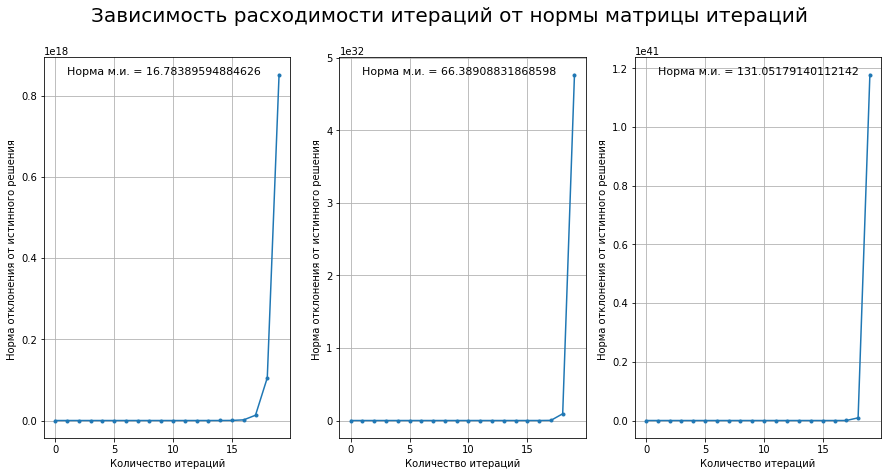

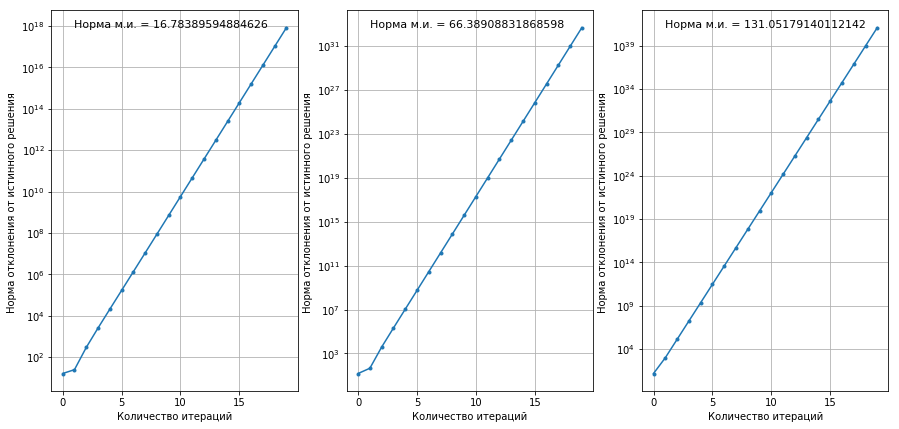

In [35]:
import numpy as np
rndm = np.random.RandomState(1234)
import matplotlib.pyplot as plt

n = 10
J = 3 # Кол-во разных значений нормы матрици итераций
I = 20 # Максимальное кол-во итераций для одного уравнения
iteracii = np.zeros((J, I))  # Следующие три строчки нужны для построения графиков
delt = np.zeros((J, I))
b_lst = []
for j in range(J):
    
    A = rndm.uniform(size=(n, n)) 
    b = rndm.uniform(size=n)
    b_lst.append(func_s(A, b, 1)[2])
    for i in range(I):
        iteracii[j][i] = i
        delt[j][i] = (np.linalg.norm(func_s(A, b, i)[1]))
    
# Таким образом у нас есть нормы  всех матриц итераций, список итераций и соответствующих им погрешностей


plt.figure(figsize=(15, 7)) # Размер картинки

plt.subplot(132) # Сетка для графиков и их расположение на ней
plt.plot(iteracii[0], delt[0], '.-')
plt.xlabel('Количество итераций')
plt.ylabel('Норма отклонения от истинного решения ')
ss = str(b_lst[0])
S = 'Норма м.и. = '
plt.text(1, np.max(delt[0]),  s =S+ss,fontsize=11) # Ввод текста на графике
plt.grid()

plt.subplot(131)
plt.plot(iteracii[1], delt[1], '.-')
plt.xlabel('Количество итераций')
plt.ylabel('Норма отклонения от истинного решения ')
ss = str(b_lst[1])
S = 'Норма м.и. = '
plt.text(1, np.max(delt[1]),  s =S+ss,fontsize=11)
plt.grid()

plt.subplot(133)
plt.plot(iteracii[2], delt[2], '.-')
plt.xlabel('Количество итераций')
plt.ylabel('Норма отклонения от истинного решения ')
ss = str(b_lst[2])
S = 'Норма м.и. = '
plt.text(1, np.max(delt[2]),  s =S+ss,fontsize=11)
plt.grid()
plt.suptitle('Зависимость расходимости итераций от нормы матрицы итераций', fontsize = 20)

# Построим те же графики, но в логарифмических осях

plt.figure(figsize=(15, 7))

plt.subplot(132)
plt.semilogy(iteracii[0], delt[0], '.-')
plt.xlabel('Количество итераций')
plt.ylabel('Норма отклонения от истинного решения ')
ss = str(b_lst[0])
S = 'Норма м.и. = '
plt.text(1, np.max(delt[0]),  s =S+ss,fontsize=11)
plt.grid()

plt.subplot(131)
plt.semilogy(iteracii[1], delt[1], '.-')
plt.xlabel('Количество итераций')
plt.ylabel('Норма отклонения от истинного решения ')
ss = str(b_lst[1])
S = 'Норма м.и. = '
plt.text(1, np.max(delt[1]),  s =S+ss,fontsize=11)
plt.grid()

plt.subplot(133)
plt.semilogy(iteracii[2], delt[2], '.-')
plt.xlabel('Количество итераций')
plt.ylabel('Норма отклонения от истинного решения ')
ss = str(b_lst[2])
S = 'Норма м.и. = '
plt.text(1, np.max(delt[2]),  s =S+ss,fontsize=11)
plt.grid()


Итерационный метод расходится (в общем случае), если норма матрицы итераций превышает 1. Результат согласуется с предсказанием (основанным на теореме из лекции).

Теперь посмотрим на сходимость итераций, когда норма матрицы итераций не превышает 1.

Text(0.5, 0.98, 'Зависимость расходимости итераций от нормы матрицы итераций')

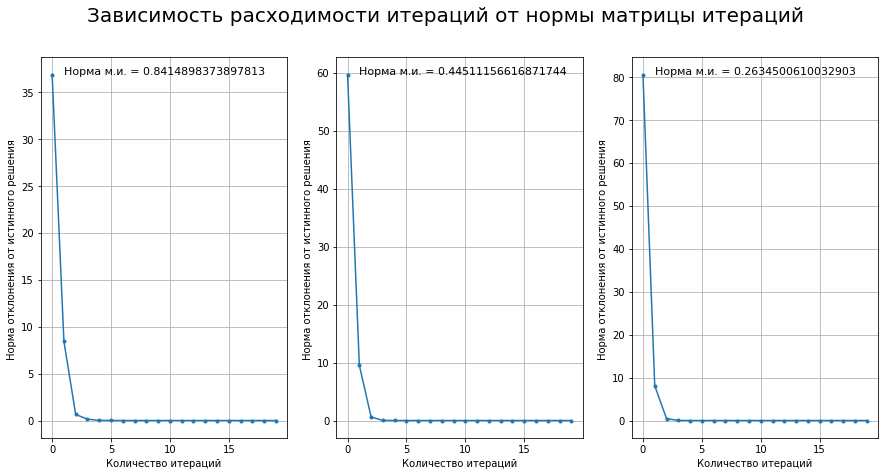

In [36]:
import numpy as np
rndm = np.random.RandomState(1234)
n = 10 # Размер матрицы A
K = 3
M = 20
iterr = np.zeros((K, M))
deltt = np.zeros((K, M))
b_lstt = []



for k in range(K):
    F = np.eye(n)
    A = rndm.uniform(size=(n, n)) + (k+1)*7*F
    b = rndm.uniform(size=n)
    b_lstt.append(func_s(A, b, 1)[2])
    for m in range(M):
        iterr[k][m] = m
        deltt[k][m] = np.linalg.norm(func_s(A, b, m)[1])


plt.figure(figsize=(15, 7)) # Размер картинки

plt.subplot(131) # Сетка для графиков и их расположение на ней
plt.plot(iterr[0], deltt[0], '.-')
plt.xlabel('Количество итераций')
plt.ylabel('Норма отклонения от истинного решения ')
ss = str(b_lstt[0])
S = 'Норма м.и. = '
plt.text(1, np.max(deltt[0]),  s =S+ss,fontsize=11) # Ввод текста на графике
plt.grid()

plt.subplot(132)
plt.plot(iterr[1], deltt[1], '.-')
plt.xlabel('Количество итераций')
plt.ylabel('Норма отклонения от истинного решения ')
ss = str(b_lstt[1])
S = 'Норма м.и. = '
plt.text(1, np.max(deltt[1]),  s =S+ss,fontsize=11)
plt.grid()

plt.subplot(133)
plt.plot(iterr[2], deltt[2], '.-')
plt.xlabel('Количество итераций')
plt.ylabel('Норма отклонения от истинного решения ')
ss = str(b_lstt[2])
S = 'Норма м.и. = '
plt.text(1, np.max(deltt[2]),  s =S+ss,fontsize=11)
plt.grid()
plt.suptitle('Зависимость расходимости итераций от нормы матрицы итераций', fontsize = 20)

Таким образом, результат согласуется с теоремой из лекции (если норма матрицы итераций не превышает 1, то присутствует сходимость).

# III. Minimum residual scheme

### Task III.1

Implement the $\textit{minimum residual}$ scheme: an explicit non-stationary method, where at each step you select the iteration parameter $\tau_n$ to minimize the residual $\mathbf{r}_{n+1}$ given $\mathbf{r}_n$. Test it on a random matrix, study the convergence to the solution, in terms of the norm of the residual and the deviation from the ground truth solution (which you can obtain using a direct method). Study how the iteration parameter $\tau_n$ changes as iterations progress.

(50% of the grade)

In [37]:
def funcr(A, b, N):
    n = np.shape(A)[0]
    x0 = np.ones(n)
    x = x0
    r = np.zeros(n)
    t_lst = []
    iter_lst = []
    nrlst =[]
    otkl = []
    for i in range(N):
        r = A @ x - b
        c = A @ r
        t = (r @ c)/(np.linalg.norm(c))**2
        x = x - t*r
        t_lst.append(t)
        iter_lst.append(i)
        nrlst.append(np.linalg.norm(r))
        otkl.append(np.linalg.norm(A@x-b))
    return x, A@x -b, np.array(iter_lst),np.array(t_lst), np.array(nrlst), np.array(otkl)


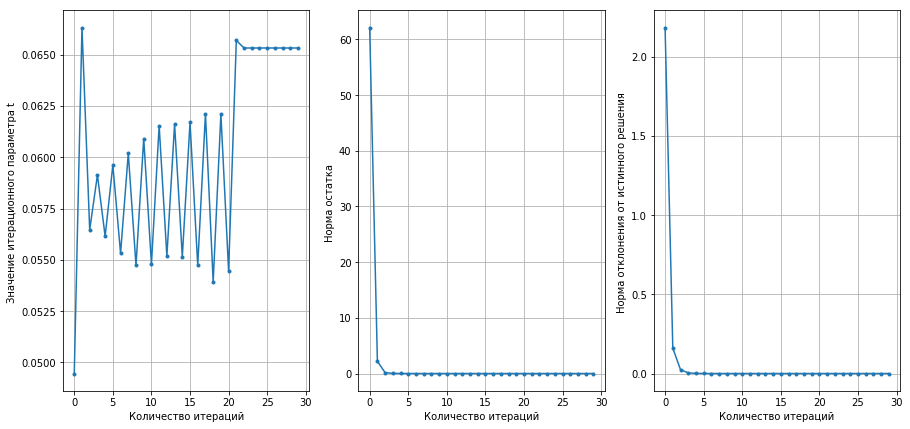

In [38]:
import numpy as np
rndm = np.random.RandomState(1234)

n = 10
A = rndm.uniform(size=(n, n)) + np.diagflat([15]*n)
b = rndm.uniform(size=n)


plt.figure(figsize=(15, 7)) # Размер картинки

plt.subplot(132) # Сетка для графиков и их расположение на ней
plt.plot(funcr(A, b, 30)[2], funcr(A, b, 30)[4], '.-')
plt.xlabel('Количество итераций')
plt.ylabel('Норма остатка ')
#ss = str(b_lst[0])
#S = 'Норма м.и. = '
#plt.text(1, np.max(delt[0]),  s =S+ss,fontsize=11) # Ввод текста на графике
plt.grid()

plt.subplot(131)
plt.plot((funcr(A, b, 30))[2], funcr(A, b, 30)[3], '.-')
plt.xlabel('Количество итераций')
plt.ylabel('Значение итерационного параметра t ')
#ss = str(b_lst[1])
#S = 'Норма м.и. = '
#plt.text(1, np.max(delt[1]),  s =S+ss,fontsize=11)
plt.grid()

plt.subplot(133)
plt.plot(funcr(A, b, 30)[2], funcr(A, b, 30)[5], '.-')
plt.xlabel('Количество итераций')
plt.ylabel('Норма отклонения от истинного решения ')
#ss = str(b_lst[2])
#S = 'Норма м.и. = '
#plt.text(1, np.max(delt[2]),  s =S+ss,fontsize=11)
plt.grid()
#plt.suptitle('Зависимость расходимости итераций от нормы матрицы итераций', fontsize = 20)


Функция прошла проверку на самой первой случайной матрице. Проверим на еще одной.

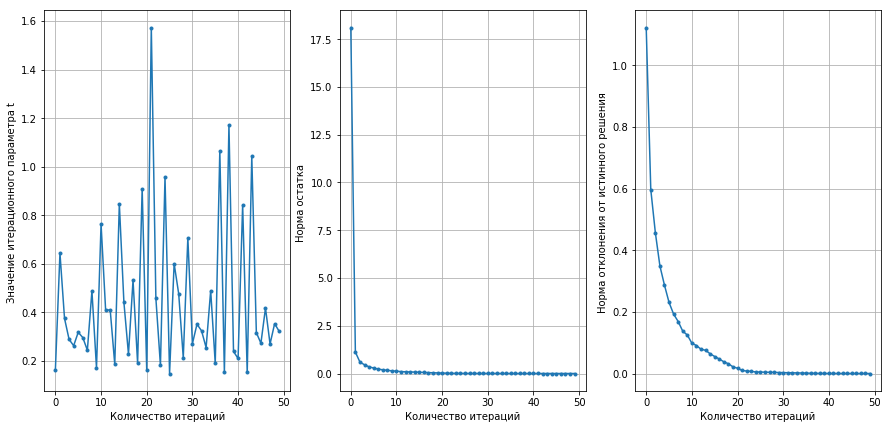

In [39]:
import numpy as np
rndm = np.random.RandomState(1234)

n = 10
A = rndm.uniform(size=(n, n)) + np.diagflat([1]*n)
b = rndm.uniform(size=n)


plt.figure(figsize=(15, 7)) # Размер картинки

plt.subplot(132) # Сетка для графиков и их расположение на ней
plt.plot(funcr(A, b, 50)[2], funcr(A, b, 50)[4], '.-')
plt.xlabel('Количество итераций')
plt.ylabel('Норма остатка ')
#ss = str(b_lst[0])
#S = 'Норма м.и. = '
#plt.text(1, np.max(delt[0]),  s =S+ss,fontsize=11) # Ввод текста на графике
plt.grid()

plt.subplot(131)
plt.plot((funcr(A, b, 50))[2], funcr(A, b, 50)[3], '.-')
plt.xlabel('Количество итераций')
plt.ylabel('Значение итерационного параметра t ')
#ss = str(b_lst[1])
#S = 'Норма м.и. = '
#plt.text(1, np.max(delt[1]),  s =S+ss,fontsize=11)
plt.grid()

plt.subplot(133)
plt.plot(funcr(A, b, 50)[2], funcr(A, b, 50)[5], '.-')
plt.xlabel('Количество итераций')
plt.ylabel('Норма отклонения от истинного решения ')
#ss = str(b_lst[2])
#S = 'Норма м.и. = '
#plt.text(1, np.max(delt[2]),  s =S+ss,fontsize=11)
plt.grid()
#plt.suptitle('Зависимость расходимости итераций от нормы матрицы итераций', fontsize = 20)
